# Stock Market Sentiment Analysis

The following Python project aims to retreive a number of articles using the Google News 

In [81]:
# Load necessary packages
import numpy as np
import pandas as pd
import requests
import json
import os
import yfinance as yf
import spacy as sp
import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import ast

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pandas_market_calendars import get_calendar
from sklearn.preprocessing import MinMaxScaler

We first set important global variables, such as the date of today.

In [98]:
nlp = sp.load("en_core_web_sm")
current_directory = os.getcwd()
os.chdir(current_directory)

# Pipeline

In [83]:
def fetch_articles(category, start_date):
    """
    Fetches articles from the specified category within the given date range using the GNews API.

    Parameters:
    - category (str): The category of articles to fetch.
    - start_date (str): The start date of the date range in 'YYYY-MM-DD' format.
    - end_date (str): The end date of the date range in 'YYYY-MM-DD' format.

    Returns:
    - list: A list of dictionaries representing the fetched articles.
    """
    
    api_key = '88edd99823231ee937f06064cd930842'
    url = f"https://gnews.io/api/v4/top-headlines?category={category}&from={start_date}&lang=en&country=us&max=100&apikey={api_key}"
    response = requests.get(url)
    articles = json.loads(response.text)['articles']
    return articles

In [84]:
def calculate_sentiment_scores(text):
    """
    Calculates sentiment scores for the given text using the VADER sentiment analysis tool.

    Parameters:
    - text (str): The text for which sentiment scores are to be calculated.

    Returns:
    - dict: A dictionary containing sentiment scores (neg, neu, pos, compound).
    """
    
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [85]:
def export_sentiment_data(sentiment_scores, date):
    """
    Exports sentiment scores data to a CSV file.

    Parameters:
    - sentiment_scores (dict): A dictionary containing sentiment scores for articles.

    Returns:
    - None
    """

    # Convert data to list of dictionaries
    data_list = []
    for title, scores in sentiment_scores.items():
        row = {'date': date, 'title': title, **scores}
        data_list.append(row)

    # Convert list of dictionaries to DataFrame
    daily_data = pd.DataFrame(data_list)
    
    # Define CSV file name
    csv_file_name = f"sentiment_scores_{date}.csv"

    # Export DataFrame to CSV file
    daily_data.to_csv(csv_file_name, index=False)

    print(f"Data has been exported to '{csv_file_name}' successfully.")

In [86]:
def export_daily_data(sentiment_scores, sp500):
    """
    Finds the file called 'daily_data.csv', loads it, and adds a new row to it.
    The new row includes date, sentiment scores, and S&P 500 data based on the parameters.

    Parameters:
    - sentiment_scores (dict): A dictionary containing sentiment scores.
    - sp500 (float): The S&P 500 data for the current date.

    Returns:
    - pd.DataFrame: The updated DataFrame containing daily data.
    """
    # Check if 'daily_data.csv' file exists
    if os.path.exists('daily_data.csv'):
        # Load existing data into a DataFrame
        daily_data = pd.read_csv('daily_data.csv')
    else:
        # Create a new DataFrame if 'daily_data.csv' doesn't exist
        daily_data = pd.DataFrame(columns=['Date', 'Sentiment_Score', 'S&P500'])

    # Get today's date
    today_date = pd.to_datetime('today').strftime('%Y-%m-%d')

    # Create a new row with today's date, sentiment scores, and S&P 500 data
    new_row = {'Date': today_date, 'Sentiment_Score': sentiment_scores, 'S&P500': sp500}

    # Append the new row to the DataFrame
    daily_data = daily_data.append(new_row, ignore_index=True)

    # Save the updated DataFrame to 'daily_data.csv'
    daily_data.to_csv('daily_data.csv', index=False)

    return daily_data

In [114]:
def export_daily_data():
    """
    Reads all CSV files in the current directory starting with 'sentiment_scores'
    and loads them into a pandas DataFrame.

    Returns:
    ----------
    pandas DataFrame: A DataFrame containing the concatenated data from all CSV files.
    """
    # Get a list of all files in the directory
    files = os.listdir(current_directory)
    
    # Filter files that start with 'sentiment_scores' and end with '.csv'
    csv_files = [file for file in files if file.startswith('sentiment_scores') and file.endswith('.csv')]
    
    # Initialize an empty list to store DataFrames
    scores = []

    daily_data = pd.DataFrame(columns=['Date', 'Sentiment_Score', 'S&P500'])
    
    # Loop through each CSV file
    for file in csv_files:
        # Construct the file path
        file_path = os.path.join(current_directory, file)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        score = {
            'neg' : df['neg'],
            'pos' : df['pos'],
            'neu' : df['neu'],
            'compound' : df['compound']
        }

        #total_score = calculate_total_daily_sentiment(score)
        #sp500 = get_sp500_price(today)
        #date = df['date'][0]

        scores.append(score)


        # Create a new row with today's date, sentiment scores, and S&P 500 data
        new_row = {'Date': date, 'Sentiment_Score': total_score, 'S&P500': sp500}

        # Append the new row to the DataFrame
        daily_data = daily_data.append(new_row, ignore_index=True)

    # Save the updated DataFrame to 'daily_data.csv'
    daily_data.to_csv('daily_data.csv', index=False)
    
    return scores

export_daily_data()

KeyError: 'neg'

In [87]:
def get_sp500_price(start_date):
    """
    Get the adjusted close price of the S&P 500 index from Yahoo Finance for a specific date.
    If the given date is not a trading day for the S&P 500, return the price for the last trading day.

    Parameters:
    - start (datetime.date): Date for which to retrieve the price.

    Returns:
    - float: Adjusted close price of the S&P 500 on the specified date or the last trading day.
    """
    # Transform the date parameter into a string
    start_date_str = start_date.strftime('%Y-%m-%d')

    # No trading day --> get latest trading day
    sp500_calendar = get_calendar('NYSE')
    if sp500_calendar.valid_days(start_date=start_date_str, end_date=start_date_str).empty:
        start_date = start_date - pd.tseries.offsets.BDay(1)
        start_date_str = start_date.strftime('%Y-%m-%d')

    # Get the next day as a string
    end_date = start_date + datetime.timedelta(days=1)
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define the ticker symbol for the S&P 500 index
    sp500_ticker = '^GSPC'  # S&P 500 index ticker symbol

    # If the given date is a trading day, fetch historical data for the S&P 500 index from Yahoo Finance
    sp500_data = yf.download(sp500_ticker, start=start_date_str, end=end_date_str)
    
    # Extract the adjusted close price for the specified date
    sp500_price = sp500_data['Adj Close'][0]
    
    return sp500_price

In [109]:
def calculate_total_daily_sentiment(scores):
    """
    Calculate the normalized total sentiment score given the daily articles.
    Parameters:
    - scores: Daily articles sentiment scores for which the total score should be calculated.

    Returns:
    - dict: A dictionary containing the neg, pos, neu and compound elements of the total daily sentiment score.
    """
    total_sentiment = {
    'neg': 0,
    'pos': 0,
    'neu': 0,
    'compound': 0
    }

    for score in scores.values():
        total_sentiment['neg'] += score['neg']
        total_sentiment['pos'] += score['pos']
        total_sentiment['neu'] += score['neu']
        total_sentiment['compound'] += score['compound']
    
    # Calculating the total sentiment scores for today
    num_articles = len(scores)
    total_sentiment['neg'] /= num_articles
    total_sentiment['neu'] /= num_articles
    total_sentiment['pos'] /= num_articles
    total_sentiment['compound'] /= num_articles

    return total_sentiment    

# Retreive articles

Using the API of Google News, we retrieve the maximum possible number of business news for today.

In [106]:
today = datetime.datetime.now().date()

# Load all possible articles for today
category = "business"
articles = fetch_articles(category, today)

# Extract both the title and the description component of all articles
descriptions = [article['description'] for article in articles]

ConnectionError: HTTPSConnectionPool(host='gnews.io', port=443): Max retries exceeded with url: /api/v4/top-headlines?category=business&from=2024-04-11&lang=en&country=us&max=100&apikey=88edd99823231ee937f06064cd930842 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fab6958bc10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

# Calculate sentiment score
Using Vader, we calculate the sentiment score for each article, as well as the given day in total.
We also retrive the daily market price for the S&P 500 and save the data together in a CSV file for each day.
For the S&P 500 prices, only trading dates can be considered, while articles can also be retreived on non-business days.
Therefore, if today's date is no trading day, the S&P 500 price of the last available trading day will be returned.

In [110]:
sentiment_scores = {}

# Text preprocessing and sentiment score calculation
for article in articles:
    current_score = calculate_sentiment_scores(article['description'])
    sentiment_scores[article['title']] = current_score

# Print sentiment score for each article
for key, value in sentiment_scores.items():
    print(key, ':', value)

# Calculate total sentiment score for today
total_sentiment = calculate_total_daily_sentiment(sentiment_scores)
print(total_sentiment)

# Getting today's SP500 price
sp500 = get_sp500_price(today)

# Saving CSV files
export_sentiment_data(sentiment_scores, today)
export_daily_data(total_sentiment, sp500)


Stock market today: Live updates : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
CHP arrests 4, recovers $300,000 in Legos stolen from Target, other SoCal stores : {'neg': 0.326, 'neu': 0.674, 'pos': 0.0, 'compound': -0.743}
Vertex to Buy Kidney Disease Drug Developer for $4.9 Billion : {'neg': 0.0, 'neu': 0.739, 'pos': 0.261, 'compound': 0.8008}
Could 99 Cents Only Stores be saved? Boss of rival dollar chain steps in to buy half the shops set to be shut : {'neg': 0.0, 'neu': 0.887, 'pos': 0.113, 'compound': 0.4215}
New Boeing Whistleblower Claims Certain Planes Could 'Break Apart' Midair : {'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'compound': -0.7845}
US food inflation is becoming Biden's major hot potato : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Bitcoin below $71,000 - Is it time to buy or sell BTC now? : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
New Jersey Transit hikes fares 15% as congestion toll looms : {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compou

IndexError: index 0 is out of bounds for axis 0 with size 0

# Diagrams & Results
Creating a Scatterplot comparing the sentiment of the individual articles.

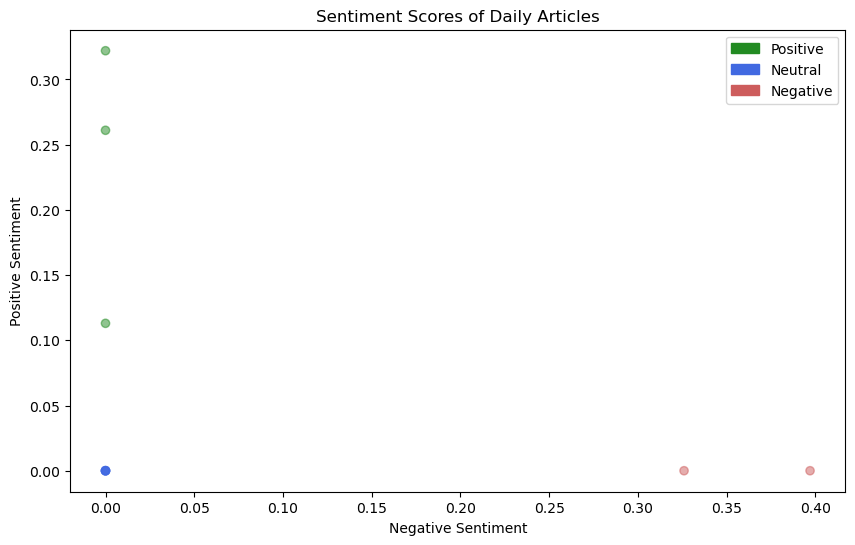

In [107]:
# Separate data for plotting
x = [article['neg'] for article in sentiment_scores.values()]
y = [article['pos'] for article in sentiment_scores.values()]
colors = ['forestgreen' if article['compound'] > 0 else 'royalblue' if article['compound'] == 0 else 'indianred' for article in sentiment_scores.values()]

# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=colors, alpha=0.5)
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Negative Sentiment')
plt.ylabel('Positive Sentiment')

# Customize legend
green_patch = mpatches.Patch(color='forestgreen', label='Positive')
blue_patch = mpatches.Patch(color='royalblue', label='Neutral')
red_patch = mpatches.Patch(color='indianred', label='Negative')

# Additional plot settings
plt.legend(handles=[green_patch, blue_patch, red_patch], loc='upper right', fontsize='medium')
plt.grid(False)
plt.show()


Creating a Heatmap comparing each sentiment score (incl. compounded) of the individual articles by title.

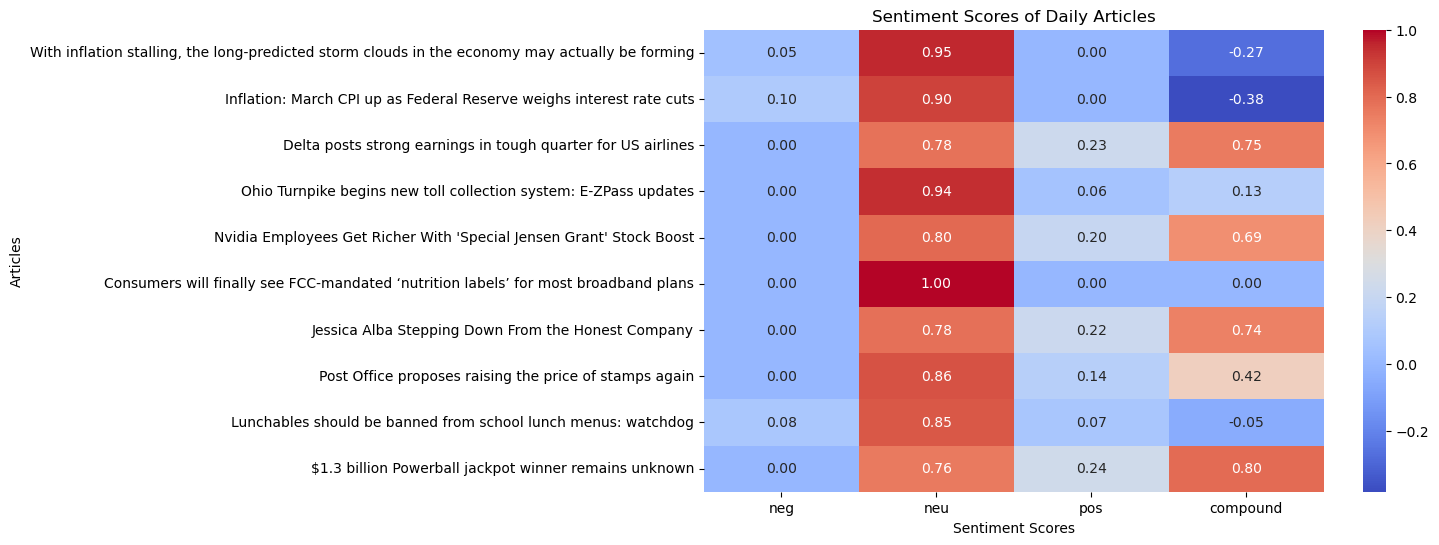

In [91]:
# Create DataFrame based on the data
daily_data = pd.DataFrame(sentiment_scores).T

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(daily_data[['neg', 'neu', 'pos', 'compound']], cmap='coolwarm', annot=True, fmt=".2f")

# Additional plot settings
plt.title('Sentiment Scores of Daily Articles')
plt.xlabel('Sentiment Scores')
plt.ylabel('Articles')
plt.show()


Creating a bar plot displaying the relative sentiment of the market, displayed as the ratio of positive and negative sentiments.
Since sentiment scores can range from -1 to 1, following thresholds values are defined:

- negative: between -1 and -0.1
- neutral: between -0.1 and 0.1
- positive: between 0.1 and 1

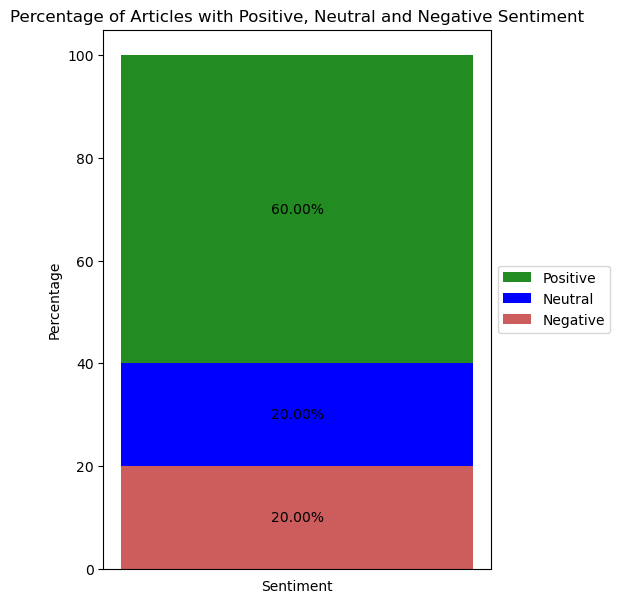

In [92]:
# Count positive and negative articles
positive_count = sum(1 for score in sentiment_scores.values() if score['compound'] > 0.1)
neutral_count = sum(1 for score in sentiment_scores.values() if score['compound'] < 0.1 and score['compound'] > -0.1)
negative_count = sum(1 for score in sentiment_scores.values() if score['compound'] < -0.1)

# Calculate percentages
total_articles = len(sentiment_scores)
positive_percent = (positive_count / total_articles) * 100
neutral_percent = (neutral_count / total_articles) * 100
negative_percent = (negative_count / total_articles) * 100

# Bar Plot
plt.figure(figsize=(5, 7))
plt.bar([0.5], [positive_percent], color='forestgreen', bottom=negative_percent + neutral_percent, label='Positive')
plt.bar([0.5], [neutral_percent], color='blue', bottom=negative_percent, label='Neutral')
plt.bar([0.5], [negative_percent], color='indianred', label='Negative')

# Add text labels
plt.text(0.5, negative_percent / 2, f'{negative_percent:.2f}%', ha='center', va='center')
plt.text(0.5, negative_percent + neutral_percent / 2, f'{neutral_percent:.2f}%', ha='center', va='center')
plt.text(0.5, negative_percent + neutral_percent + positive_percent / 2, f'{positive_percent:.2f}%', ha='center', va='center')

# Additional plot settings
plt.title('Percentage of Articles with Positive, Neutral and Negative Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.xticks([])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Position legend to the right outside of the diagram
plt.show()


# Historic Data & Trend Analysis

We first load the data from daily_data.csv containing the total sentiment score and the S&P 500's price for each day of the observation period.

In [93]:
daily_data = pd.read_csv('daily_data.csv', index_col=0, delimiter=',')
daily_data

,Sentiment_Score,S&P500
Date,,
2024-04-06,"{'neg': 0.0126, 'pos': 0.1312, 'neu': 0.8561, ...",5164.470215
2024-04-07,"{'neg': 0.0126, 'pos': 0.1312, 'neu': 0.8561, ...",5164.029785
2024-04-10,"{'neg': 0.022699999999999998, 'pos': 0.1153999...",5209.910156
2024-04-10,"{'neg': 0.022699999999999998, 'pos': 0.1153999...",5157.620117


In [94]:
test = daily_data['Sentiment_Score'].values

We display the trend using a line chart.

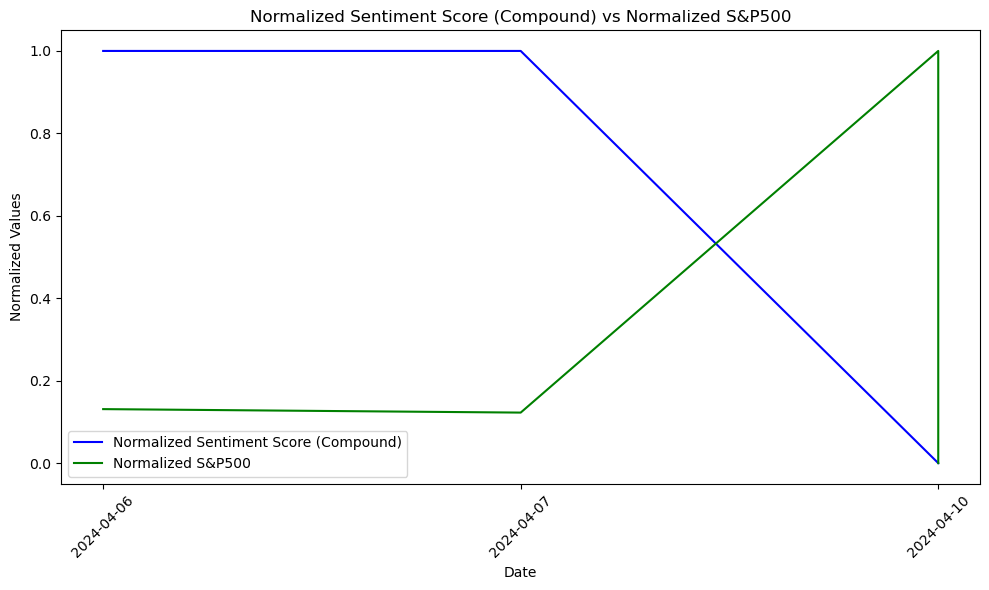

In [95]:
# Convert string representations of dictionaries to actual dictionaries
daily_data['Sentiment_Score'] = daily_data['Sentiment_Score'].apply(ast.literal_eval)

# Extracting compound sentiment scores and S&P500 values
compound_scores = [score['compound'] for score in daily_data['Sentiment_Score']]
s_and_p = daily_data['S&P500']

# Normalize the values
scaler = MinMaxScaler()
compound_scores_normalized = scaler.fit_transform(np.array(compound_scores).reshape(-1, 1)).flatten()
s_and_p_normalized = scaler.fit_transform(np.array(s_and_p).reshape(-1, 1)).flatten()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, compound_scores_normalized, label='Normalized Sentiment Score (Compound)', color='blue')
plt.plot(daily_data.index, s_and_p_normalized, label='Normalized S&P500', color='green')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Normalized Sentiment Score (Compound) vs Normalized S&P500')
plt.xticks(rotation=45)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()
